## Recreate dotplots in Figures 2G, 3A, S3A 

In [1]:
library(ggplot2)
library(cowplot)
library(RColorBrewer)

In [ ]:
# MinMax <- function (data, min, max) {
  data2 <- data
  data2[data2 > max] <- max
  data2[data2 < min] <- min
  return(data2)
}

### Read in data and gene lists

In [3]:
# read in normalised cell counts and metadata
counts <- as.matrix(read.table("~/Downloads/Aug20_BLZ_data/Ctl+Blz_counts_18529x40930_Aug20.txt", 
                               sep="\t", header=T, row.names=1))

cell_meta <- read.table("~/Downloads/Aug20_BLZ_data/All_cells_meta_iter3_Aug20.txt", 
                        sep="\t", header=T)

counts_meta.df <- cbind(counts, cell_meta)

In [80]:
counts_meta.df$X.population <- as.factor(counts_meta.df$X.population)
counts_meta.df$condition <- as.factor(counts_meta.df$condition)

In [81]:
## M1 genes - final
m1_genes <- sort(c('Cd80', 'Cd86', 'Tlr2', 'Tlr4', 'Nos2', 
                   'Socs3', 'Tnf', 'Il6', 'Il12b', 'Il23a'))

# M2 genes - final
m2_genes <- sort(c('Cd163', 'Msr1', 'Mrc1', 'Tgm2', 'Chil3', 
                   'Chil4', 'Retnla', 'Arg1', 'Il10', 'Tgfb1')) 

m_genes <- c(m1_genes, m2_genes)

# # Alternatively - ICR genes 
# genes <- c('Il12b', 'Ifng', 'Tbx21', 'Irf1', 'Stat1', 
#            'Gzma', 'Gzmb', 'Prf1', 'Cxcl9', 'Cxcl10', 'Ccl5')

In [82]:
# meta names
meta <- c('condition', 'X.population', 'X.major.TNK')
cols <- c(m_genes, meta)

In [83]:
# subset data on gene and meta columns
counts.meta <- counts_meta.df[,cols]

In [84]:
# remove non-MoMac/MonoDC cells
rmv <- c('B cells', 'Basophils', 'DC', 'ILC', 'Neutrophils', 
         'NK/T', 'pDC', 'Plasma cells', 'Tgd', 'Treg')
counts.meta <- counts.meta[!(counts.meta$X.major.TNK %in% rmv),]

In [85]:
# unfactor factors
i <- sapply(counts.meta, is.factor)
counts.meta[i] <- lapply(counts.meta[i], as.character)

In [105]:
# specify cell order for side by side analysis
cell.order <- c("Mono1", "Mono2", "Mono3", "Mac1", 
                "Mac2", "Mac3", "Mac4", "MonoDC")
cell.order <- paste0(rep(cell.order, each=2), c(" Vehicle", " CSF1Ri"))

In [87]:
# segregate cell populations by condition
counts.meta <- within(counts.meta, 
                      major_trt <- paste(X.major.TNK, condition, sep=" "))
counts.meta <- within(counts.meta, 
                      minor_trt <- paste(X.population, condition, sep=" "))

## Format for plotting

In [41]:
# find avg expression and logFC(ave exp) of each gene for each cluster
# vector function to calculate avg exp and fold change(ave exp) for each gene
data.plot <- lapply(X = unique(x = counts.meta$minor_trt), FUN = function(ident) {
  data.use <- counts.meta[counts.meta$minor_trt==ident, 1:(ncol(x = counts.meta) - 5), drop=F]
  # calculate ave expression in blz
  avg.exp <- apply(X = data.use, MARGIN=2, mean)
  # calculate pct exp
  pct.exp <- apply(X = data.use, MARGIN = 2, FUN = function(x, threshold) {
    return(length(x = x[x > threshold]) / length(x = x) * 100)
  }, threshold = 0)
  return(list(avg.exp = avg.exp, pct.exp = pct.exp))
})

# restructure into dataframe
names(data.plot) <- unique(x = counts.meta$minor_trt)
data.plot <- lapply(X = names(x = data.plot), FUN = function(x) {
  data.use <- as.data.frame(x = data.plot[[x]])
  data.use$features.plot <- rownames(x = data.use)
  data.use$id <- x
  return(data.use)
})
data.plot <- do.call(what = "rbind", args = data.plot)

In [42]:
# for missing identities (e.g. Mono2 vehicle, add NA rows to the dataframe)

for (i in setdiff(cell.order, unique(data.plot$id))) {
    tmp <- data.frame(avg.exp=NA, pct.exp=NA, 
           features.plot=unique(data.plot$features.plot), 
           id=i,
           row.names=unique(data.plot$features.plot))
    data.plot <- rbind(data.plot, tmp)
}

In [43]:
# define some fixed variables for graphing
NUM_IDS <- length(unique(data.plot$id))
NUM_GS <- length(m_genes)

Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”


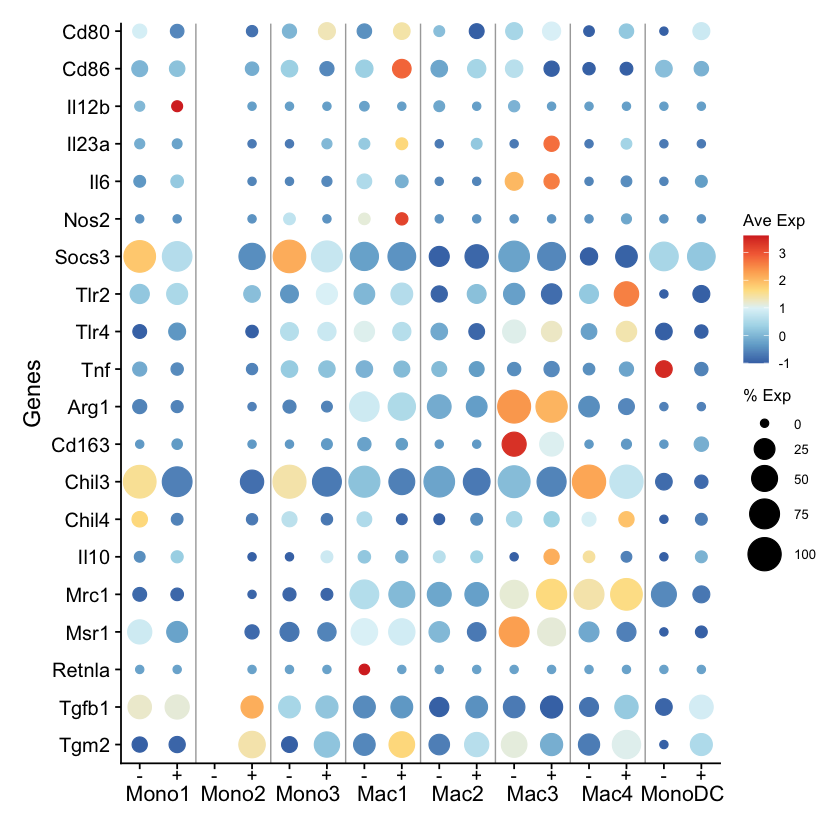

In [45]:
# scale avg expression level of genes
avg.exp.scaled <- sapply(X = unique(x = data.plot$features.plot), 
                         FUN = function(x) {
                           data.use <- data.plot[data.plot$features.plot == 
                                                   x, "avg.exp"]
                           data.use <- scale(x = data.use)
                           data.use <- MinMax(data = data.use, min = -1, 
                                              max = 5)
                           return(data.use)
                         })

avg.exp.scaled <- as.vector(x = t(x = avg.exp.scaled))
data.plot$avg.exp.scaled <- avg.exp.scaled

# fix row and column order
data.plot$features.plot <- factor(data.plot$features.plot, levels=rev(m_genes))
cell.order <- cell.order
data.plot$id <- factor(data.plot$id, levels=cell.order)

# # make the plot
plot <- ggplot() + theme_cowplot() +
  geom_point(data=data.plot, mapping = aes_string(x="id", y="features.plot", 
                                                  size="pct.exp", color="avg.exp.scaled")) +
  scale_color_gradientn(colors=rev(brewer.pal(8, 'RdYlBu')), guide="colourbar") +
  scale_size_continuous(range=c(2,9)) +
  guides(size = guide_legend(title = "% Exp", title.theme=element_text(size=10), 
                             label.theme=element_text(size=8), nrow=5)) +
  guides(color = guide_colorbar(title = "Ave Exp", title.theme=element_text(size=10), 
                                label.theme=element_text(size=8))) +
  labs(y = "Genes") +
  theme(legend.position = "right") +
  theme(axis.text.x=element_blank(), axis.title.x=element_blank(), plot.margin = unit(c(0.5,0.5,1.5,0.5), "cm")) + 
  annotate(geom = "text", x = seq_len(NUM_IDS), y = 0.2, label = rep(c("-", "+"), times=(NUM_IDS/2)), size = 4) +
  annotate(geom = "text", x = 1.5 + 2 * (0:(NUM_IDS/2-1)), y = -0.3, 
           label = c("Mono1", "Mono2", "Mono3", "Mac1", 
                     "Mac2", "Mac3", "Mac4", "MonoDC"), 
           size = 4.5) +
  coord_cartesian(ylim = c(0.5, NUM_GS+0.2), xlim = c(0.5, NUM_IDS+0.5), expand=F, clip="off") +
  # theme(text=element_text(family="Myriad Pro")) +
  geom_vline(xintercept=seq(2.5, NUM_IDS, 2), 
             lwd=0.4, colour="darkgrey")      # add dividing lines btwn celltypes
plot

ggsave(plot, file="~/DotPlot_M1+M2-genes_BLZ_SepVehBlz_v2.png", width=8, height=8.5)
